# 🍽️ **Fine-tuning GPT-2 Medium for a Cooking-Themed Model**


## 🎯 **Project Objective**  

The goal of this project is to fine-tune a **GPT-2 Medium** model using a **custom dataset generated by Phi-2**, focusing on the theme of **cooking**. This fine-tuned model will be specialized in generating relevant and creative content related to recipes, cooking techniques, ingredient pairings, and other culinary-related topics.  

## 📌**Methodology**

1. **Dataset Generation**  
   - A dataset will be created using **Phi-2**, which will generate high-quality text samples centered around cooking.  
   - The dataset will be curated and formatted to fit the fine-tuning process of GPT-2.  

2. **Fine-Tuning GPT-2**  
   - A **GPT-2 Medium** model will be fine-tuned using the generated dataset.  
   - Optimization techniques such as **gradient accumulation, mixed precision training (fp16), and learning rate scheduling** will be applied to improve efficiency.  
   - The model will be trained for multiple epochs with appropriate evaluation and checkpointing strategies.  

3. **Integration into a Web App**  
   - Once the model is fine-tuned, it will be integrated into a **web application**.  
   - The app will be hosted **locally**, allowing users to interact with the model in real-time for cooking-related queries.  
   - The backend will handle model inference, while the frontend will provide an intuitive user interface for seamless interactions.  


## 🚀 **Final Goal**

At the end of the project, the **custom GPT-2 cooking model** will be deployed on a locally hosted **web platform**, making it accessible for users who want AI-generated cooking assistance, personalized recipe suggestions, and culinary insights.  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
pip install datasets ace_tools

In [3]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
import re
import json
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset

In [4]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.4


In [5]:
# 1️⃣ Télécharger le modèle et le tokenizer
model_name = "gpt2-medium"  # Modèle GPT-2 Medium
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Vérifier si un GPU est disponible et utiliser CUDA si possible
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

# **🤖 Configuring Generation Parameters for a Cooking Assistant LLM**

When working with **Large Language Models (LLMs)**, defining **generation configurations** helps fine-tune the model’s behavior based on the required task. This project involves **fine-tuning GPT-2 Medium** for a **cooking assistant**, and the following configurations ensure the model delivers either **precise instructions** or **creative suggestions** depending on user needs.  

# 🚀 GPT-2 Text Generation Configurations  

Fine-tuning the text generation process in **GPT-2** requires adjusting key parameters to **optimize coherence, creativity, and response length**. Below, we outline **five different generation profiles**, each tailored to specific needs.  

## **📋 List of Generation Configurations**  

| **Profile Name**         | **Description**                                              | **Key Parameters**                                         |
|-------------------------|------------------------------------------------|------------------------------------------------|
| **Balanced and Coherent** | Ensures responses are diverse yet contextually relevant.  | `do_sample=True`, `temperature=0.7`, `top_k=50`, `max_new_tokens=150`, `repetition_penalty=1.2`  |
| **Creative Exploration** | Encourages imaginative and varied text generation.         | `do_sample=True`, `temperature=0.85`, `top_p=0.9`, `max_new_tokens=200`, `repetition_penalty=1.1`  |
| **Concise and Focused**  | Generates short, precise responses with minimal repetition. | `do_sample=False`, `temperature=0.6`, `max_new_tokens=100`, `repetition_penalty=1.3`  |
| **Extended and Detailed** | Produces long, in-depth responses for comprehensive topics. | `do_sample=True`, `temperature=0.75`, `top_k=100`, `max_new_tokens=300`, `repetition_penalty=1.15`  |
| **High Precision**       | Aims for highly accurate and contextually relevant outputs. | `do_sample=False`, `temperature=0.65`, `top_p=0.8`, `max_new_tokens=150`, `repetition_penalty=1.25`  |

## **🔑 Key Parameters Explained**  

### **1️⃣ `do_sample` (Enable Sampling)**
Controls whether the model should **randomly sample from the probability distribution of possible words**.  
- **`True`** → Introduces randomness, making responses more diverse and creative.  
- **`False`** → Uses the most probable word at each step, leading to **more deterministic** outputs.  

### **2️⃣ `temperature` (Creativity Control)**
Determines how **random or focused** the text generation is.  
- **Lower values (e.g., 0.6)** → More predictable and logical responses.  
- **Higher values (e.g., 0.85)** → More creative and varied outputs.  

### **3️⃣ `top_k` (Restricted Token Selection)**
Limits the number of most probable tokens considered at each step.  
- **A lower value (e.g., 50)** → More structured responses.  
- **A higher value (e.g., 100)** → More diverse and spontaneous responses.  

### **4️⃣ `top_p` (Nucleus Sampling)**
Instead of selecting the top **k** tokens, `top_p` chooses the **smallest number of tokens** whose cumulative probability **exceeds the threshold `p`**.  
- **`top_p=0.9`** → Allows more variety while keeping coherence.  
- **Lower values (e.g., 0.8)** → More deterministic and structured outputs.  

### **5️⃣ `repetition_penalty` (Avoiding Repetition)**
Discourages the model from repeating words or phrases.  
- **Values > 1.0 (e.g., 1.2 or 1.3)** → Reduces redundancy in generated text.  

### **6️⃣ `max_new_tokens` (Output Length Control)**
Sets the **maximum number of tokens** the model can generate per response.  
- **Lower values (e.g., 100)** → Short and to-the-point responses.  
- **Higher values (e.g., 300)** → More elaborate and detailed responses.  

## **🎯 Choosing the Right Configuration**  

| **Use Case**                                    | **Recommended Profile**        |
|------------------------------------------------|--------------------------------|
| Generating a structured, logical answer        | **Balanced and Coherent**      |
| Creating unique and creative ideas             | **Creative Exploration**       |
| Generating short, factual responses            | **Concise and Focused**        |
| Writing detailed explanations or long texts    | **Extended and Detailed**      |
| Producing precise, well-researched answers     | **High Precision**             |



In [39]:
# List of generation configurations
generation_configs = [
    {
        "name": "Balanced and Coherent",
        "description": "Ensures outputs are both diverse and contextually relevant.",
        "params": {
            "do_sample": True,  # Enables sampling for variability
            "temperature": 0.7,  # Balances randomness and determinism
            "top_k": 50,  # Considers the top 50 token options
            "max_new_tokens": 150,  # Limits the length of the generated text
            "repetition_penalty": 1.2  # Discourages repetitive phrases
        }
    },
    {
        "name": "Creative Exploration",
        "description": "Encourages imaginative and varied text generation.",
        "params": {
            "do_sample": True,
            "temperature": 0.85,  # Increases randomness for creativity
            "top_p": 0.9,  # Nucleus sampling for broader token selection
            "max_new_tokens": 200,
            "repetition_penalty": 1.1
        }
    },
    {
        "name": "Concise and Focused",
        "description": "Generates brief and to-the-point responses.",
        "params": {
            "do_sample": False,  # Deterministic output
            "temperature": 0.6,  # Lower temperature for focused responses
            "max_new_tokens": 100,
            "repetition_penalty": 1.3
        }
    },
    {
        "name": "Extended and Detailed",
        "description": "Produces longer, in-depth responses suitable for comprehensive topics.",
        "params": {
            "do_sample": True,
            "temperature": 0.75,
            "top_k": 100,
            "max_new_tokens": 300,  # Allows for extended text generation
            "repetition_penalty": 1.15
        }
    },
    {
        "name": "High Precision",
        "description": "Aims for accurate and contextually precise outputs.",
        "params": {
            "do_sample": False,
            "temperature": 0.65,
            "top_p": 0.8,
            "max_new_tokens": 150,
            "repetition_penalty": 1.25
        }
    }
]

# Display available configurations
for config in generation_configs:
    print(f"🔹 Profile: {config['name']}")
    print(f"   📌 Description: {config['description']}")
    print(f"   ⚙️ Parameters: {config['params']}\n")


🔹 Profile: Balanced and Coherent
   📌 Description: Ensures outputs are both diverse and contextually relevant.
   ⚙️ Parameters: {'do_sample': True, 'temperature': 0.7, 'top_k': 50, 'max_new_tokens': 150, 'repetition_penalty': 1.2}

🔹 Profile: Creative Exploration
   📌 Description: Encourages imaginative and varied text generation.
   ⚙️ Parameters: {'do_sample': True, 'temperature': 0.85, 'top_p': 0.9, 'max_new_tokens': 200, 'repetition_penalty': 1.1}

🔹 Profile: Concise and Focused
   📌 Description: Generates brief and to-the-point responses.
   ⚙️ Parameters: {'do_sample': False, 'temperature': 0.6, 'max_new_tokens': 100, 'repetition_penalty': 1.3}

🔹 Profile: Extended and Detailed
   📌 Description: Produces longer, in-depth responses suitable for comprehensive topics.
   ⚙️ Parameters: {'do_sample': True, 'temperature': 0.75, 'top_k': 100, 'max_new_tokens': 300, 'repetition_penalty': 1.15}

🔹 Profile: High Precision
   📌 Description: Aims for accurate and contextually precise outpu

# 📝 **Text Generation and Cleaning Utilities**

This module provides **text generation** functionality using a fine-tuned GPT-2 model and **post-processing utilities** to clean and format the generated text.

## **🚀 Text Generation Function**  

### **🔹 `generate_text(prompt: str, config_name: str) -> str`**  
Generates text based on the selected **generation configuration**.  

#### **📌 Arguments:**  
- **`prompt (str)`** → The input text prompt.  
- **`config_name (str)`** → The name of the generation configuration to use.  

#### **🔄 Process:**  
1. Finds the appropriate **generation configuration** by name.  
2. **Encodes** the input prompt into token IDs.  
3. Generates text using the **GPT-2 model** with the selected configuration parameters.  
4. Decodes the output into a readable format.  

#### **⚙️ Example Usage:**  
```python
generated_text = generate_text("How do I bake a chocolate cake?", "Creative and Adaptable")
print(generated_text)
```

#### **⚠️ Error Handling:**  
- If the provided **config_name** is not found, a `ValueError` is raised, listing available configurations.  

In [28]:
def generate_text(prompt: str, config_name: str) -> str:
    """
    Generates text based on the specified generation configuration.

    Args:
        prompt (str): The input text prompt.
        config_name (str): The name of the generation configuration to use.

    Returns:
        str: The generated text.
    """
    # Find the configuration by name
    config = next((cfg for cfg in generation_configs if cfg["name"] == config_name), None)

    if config is None:
        raise ValueError(f"Configuration '{config_name}' not found. Available options: {[cfg['name'] for cfg in generation_configs]}")

    # ✅ Assigner le token de padding si ce n'est pas déjà fait
    tokenizer.pad_token = tokenizer.eos_token

    # ✅ Tokenization avec attention_mask pour une meilleure qualité de génération
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Generate text using the selected configuration
    output = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        **config["params"],  # Unpack parameters from the selected configuration
        pad_token_id=tokenizer.eos_token_id  # Ensure proper padding if needed
    )

    # Decode the generated output
    return tokenizer.decode(output[0], skip_special_tokens=True)

## **🛠 Text Cleaning Functions**  

### **🔹 `clean_generated_text(text: str) -> str`**  
Cleans and formats the generated text to remove **extra spaces, stray punctuation, and formatting issues**.  

#### **📌 Cleaning Process:**  
✅ **Removes stray dots** (`"."`) at the start of lines.  
✅ **Fixes excessive spaces** before punctuation.  
✅ **Ensures proper formatting** for numbered lists.  
✅ **Reduces multiple newlines** to a single newline.  

#### **⚙️ Example Usage:**  
```python
raw_text = "Here is your recipe.. \n 1.  Preheat oven \n \n 2.  Mix ingredients. "
clean_text = clean_generated_text(raw_text)
print(clean_text)
```

In [29]:
def clean_generated_text(text: str) -> str:
    """
    Cleans and formats the generated text to remove extra newlines, spaces, and stray punctuation.

    Args:
        text (str): Raw generated text.

    Returns:
        str: Formatted and cleaned text.
    """
    # Remove stray dots at the beginning of a line
    text = re.sub(r"\n\s*\.", "\n", text)

    # Ensure proper spacing around punctuation
    text = re.sub(r"\s+\.", ".", text)  # Remove extra spaces before periods
    text = re.sub(r"\.\s*\.", ".", text)  # Fix multiple consecutive periods

    # Normalize newlines and lists (Ensure proper numbering)
    text = re.sub(r"\n\s*(\d+)\.\s*", r"\n\1. ", text)  # Ensure numbered lists are formatted correctly

    # Trim excessive newlines
    text = re.sub(r"\n{2,}", "\n", text).strip()

    return text

### **🔹 `clean_incomplete_sentences(text: str) -> str`**  
Ensures that the generated text only contains **complete sentences**, removing incomplete or cut-off phrases.  

#### **📌 Cleaning Process:**  
✅ **Splits text into sentences** while preserving formatting.  
✅ **Removes phrases** that do not end with proper punctuation (`.!?`).  
✅ **Maintains sentence structure and readability**.  

#### **⚙️ Example Usage:**  
```python
text = "Start by heating the oven. Then add the flour and mix with..."
cleaned_text = clean_incomplete_sentences(text)
print(cleaned_text)
```  


In [30]:
def clean_incomplete_sentences(text):
    """
    Slice the input text into sentences, keeping the formatting
    (e.g., \n, spaces), and remove incomplete phrases that do not
    end with a proper punctuation mark.
    """
    # Split the text while keeping the delimiters (e.g., .!?) and formatting
    sentences = re.split(r'(?<=[.!?])(\s+)', text)

    cleaned_text = ""
    for i in range(0, len(sentences) - 1, 2):  # Process sentences with their trailing spaces
        sentence = sentences[i]
        trailing_space = sentences[i + 1]
        if re.search(r'[.!?]$', sentence):  # Check if the sentence ends with valid punctuation
            cleaned_text += sentence + trailing_space

    # Handle cases where the last part is an incomplete sentence
    if len(sentences) % 2 != 0 and re.search(r'[.!?]$', sentences[-1]):
        cleaned_text += sentences[-1]

    return cleaned_text

# 🔥 **Fine-Tuning GPT-2 for a Cooking Assistant**

This section details the **fine-tuning process** of a **GPT-2 Medium** model using a dataset of cooking-related prompts. The dataset is stored in **JSON format** and contains structured data with **instructions, inputs, and expected responses**.  

## **📥 Step 1: Load the Dataset**  

First, we load the dataset from **Google Drive** and parse the JSON file.  


In [ ]:
torch.cuda.empty_cache()

# Définir le chemin du fichier dans Google Drive
json_path = "/content/drive/Shareddrives/LLM - DailyAssistant/V2_cooking_prompts_final_response.json"

# Charger le fichier JSON
with open(json_path, 'r', encoding='utf8') as f:
    data = json.load(f)


## **🔄 Step 2: Preprocess the Data**  

The dataset contains **instructions, optional inputs, and responses**. We preprocess each example into a structured prompt format suitable for fine-tuning.  


In [ ]:
def preprocess(example):
    # Construire le prompt en fonction des clés présentes
    prompt = f"Instruction: {example['instruction']}\n"
    if "input" in example and example["input"]:  # Vérifie si 'input' existe et n'est pas vide
        prompt += f"Input: {example['input']}\n"
    prompt += f"Output: {example['response']}"  # Utilisation correcte de 'response'

    return {"text": prompt}

## **📊 Step 3: Split the Dataset**  

We split the dataset into **training (80%)** and **evaluation (20%)** sets to ensure proper validation during fine-tuning.  

In [ ]:
from sklearn.model_selection import train_test_split

# Step 3: Split the dataset into training and evaluation sets
train_data, eval_data = train_test_split(data, test_size=0.2, random_state=42)

# Convert train and eval data into Hugging Face Datasets
train_dataset = Dataset.from_list(train_data).map(preprocess)
eval_dataset = Dataset.from_list(eval_data).map(preprocess)

## **📝 Step 4: Tokenize the Data**  

To train the model efficiently, we **tokenize** the text using a **GPT-2 tokenizer**, ensuring proper padding and truncation.  


In [15]:
# Step 4: Tokenize the dataset
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

def tokenize(example):
    encoding = tokenizer(example["text"], padding="max_length", truncation=True, max_length=512)
    encoding["labels"] = encoding["input_ids"].copy()  # ✅ Ajoute les labels pour la perte
    return encoding

train_dataset = train_dataset.map(tokenize, batched=True)
eval_dataset = eval_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/923 [00:00<?, ? examples/s]

Map:   0%|          | 0/231 [00:00<?, ? examples/s]

# **🍽️ Fine-Tuning GPT-2 for Cooking Assistance**

Once the dataset is **preprocessed and tokenized**, we proceed to **fine-tuning** the **GPT-2 Medium** model using **Hugging Face's Trainer API**. The training process optimizes the model to generate relevant cooking instructions, recipe suggestions, and ingredient pairings.  


## **⚙️ Step 5: Define Training Arguments**  

We define **hyperparameters** for training, evaluation, and optimization using `TrainingArguments`. These parameters help balance **learning efficiency, stability, and computational performance**.


In [16]:
from transformers import TrainingArguments

# training_args = TrainingArguments(
#     output_dir="./model_finetuned_V3",
#     run_name="GPT2_Cuisine_FT_V3",  # Nom clair pour le suivi des expériences
#     overwrite_output_dir=True,

#     # 🚀 Training setup
#     num_train_epochs=6,  # ✅ Suffisant pour un premier test, éviter le sur-ajustement
#     per_device_train_batch_size=4,  # ✅ Ajustable selon la mémoire GPU disponible
#     per_device_eval_batch_size=4,  # ✅ Même taille que le batch d'entraînement
#     gradient_accumulation_steps=8,  # ✅ Simule un batch plus grand (32)

#     # 📉 Optimisation
#     learning_rate=2e-5,  # ✅ Stable pour GPT-2
#     weight_decay=0.01,  # ✅ L2 Regularization
#     warmup_ratio=0.1,  # ✅ 10% de warmup pour stabiliser l'apprentissage

#     # 🏋️‍♂️ Checkpoints & Logging
#     save_strategy="steps",
#     save_steps=30,  # ✅ Sauvegarde toutes les 200 étapes
#     save_total_limit=2,  # ✅ Garde les 2 derniers modèles seulement
#     logging_dir="./logs",
#     logging_steps=30,  # ✅ Journalisation toutes les 50 étapes

#     # 📊 Évaluation
#     evaluation_strategy="steps",
#     eval_steps=30,  # ✅ Évaluation toutes les 200 étapes

#     # 🚀 Accélération
#     fp16=True,  # ✅ Utilisation du Float16 (si GPU supporte)
#     dataloader_num_workers=2,  # ✅ Optimisation des performances I/O
# )


In [17]:
training_args = TrainingArguments(
    output_dir="./model_finetuned_V3",
    run_name="GPT2_Cuisine_FT_V3",
    overwrite_output_dir=True,

    # 🚀 Training setup
    num_train_epochs=15,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,

    # 📉 Optimisation
    learning_rate=1e-5,
    weight_decay=0.005,
    warmup_ratio=0.15,

    # 📊 Évaluation & Journalisation
    evaluation_strategy="epoch",
    logging_strategy="epoch",

    # 🚀 Accélération
    fp16=True,
    dataloader_num_workers=2,
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## **🏋️‍♂️ Step 6: Define and Run the Trainer**  

We now create a **Trainer** object, which manages the training process by handling **dataset feeding, optimization, evaluation, and logging**.  


In [18]:
# Step 6: Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

<ipython-input-18-ca5d4c7eecde>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


After defining the trainer, we start the fine-tuning process:  


In [19]:
trainer.train()

wandb: Currently logged in as: lucien-laumont (lucien-laumont-esiee-paris) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
0,6.979500,4.612257
1,2.313100,0.769312
2,0.796900,0.617516
3,0.662700,0.570573
4,0.617300,0.551773
5,0.594900,0.540052
6,0.574400,0.531405
7,0.558200,0.524721
8,0.547900,0.520843
9,0.537600,0.516645


TrainOutput(global_step=420, training_loss=1.1190812792096818, metrics={'train_runtime': 2104.1723, 'train_samples_per_second': 6.58, 'train_steps_per_second': 0.2, 'total_flos': 1.2637759051137024e+16, 'train_loss': 1.1190812792096818, 'epoch': 14.969696969696969})

# 📊 **Model Evaluation & Saving the Fine-Tuned GPT-2**

After fine-tuning the **GPT-2 Medium** model, we evaluate its performance on the test dataset and visualize the **training loss curve**. Finally, we save the fine-tuned model for deployment in a web application.  

## **📈 Step 7: Evaluate the Fine-Tuned Model**  

Once training is complete, we evaluate the model's performance using the **Trainer API**.  

In [20]:
eval_results = trainer.evaluate()
print(f"Final evaluation results: {eval_results}")

Final evaluation results: {'eval_loss': 0.5094907283782959, 'eval_runtime': 11.9903, 'eval_samples_per_second': 19.266, 'eval_steps_per_second': 4.837, 'epoch': 14.969696969696969}


## **📉 Step 8: Analyze Training Loss**  

To monitor how well the model **learned over time**, we extract and visualize the **training loss** logged during fine-tuning.   

In [21]:
import numpy as np
train_losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
print(f"Average training loss: {np.mean(train_losses)}")

Average training loss: 1.11908


## **📊 Step 9: Visualize Training Loss Curve**  

A **loss curve** helps diagnose potential training issues, such as overfitting or underfitting.  

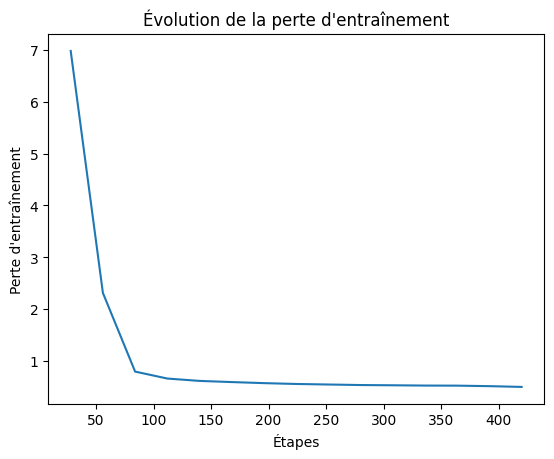

In [22]:
import matplotlib.pyplot as plt

steps = [log["step"] for log in trainer.state.log_history if "loss" in log]
losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]

plt.plot(steps, losses)
plt.xlabel("Étapes")
plt.ylabel("Perte d'entraînement")
plt.title("Évolution de la perte d'entraînement")
plt.show()

## **💾 Step 10: Save the Fine-Tuned Model**  

After evaluation, we **save the model and tokenizer** so they can be loaded later for inference in a web application.  

In [23]:
# Step 8: Save the fine-tuned model

model.save_pretrained("/content/drive/Shareddrives/LLM - DailyAssistant/model_finetuned_V3")
tokenizer.save_pretrained("/content/drive/Shareddrives/LLM - DailyAssistant/model_finetuned_V3")

('/content/drive/Shareddrives/LLM - DailyAssistant/model_finetuned_V3/tokenizer_config.json',
 '/content/drive/Shareddrives/LLM - DailyAssistant/model_finetuned_V3/special_tokens_map.json',
 '/content/drive/Shareddrives/LLM - DailyAssistant/model_finetuned_V3/vocab.json',
 '/content/drive/Shareddrives/LLM - DailyAssistant/model_finetuned_V3/merges.txt',
 '/content/drive/Shareddrives/LLM - DailyAssistant/model_finetuned_V3/added_tokens.json')

With this final step, the **GPT-2 cooking assistant** is ready for deployment in a **web-based AI assistant**, capable of generating **cooking instructions, recipes, and ingredient suggestions**! 🍽️🚀🔥

In [41]:
import re
import pandas as pd

# Define 5 cooking-related questions
questions = [
    ("Can you create for me a soup with potatoes ?", "Balanced and Coherent"),
    ("What are the best tips to improve my cooking skills ?", "Balanced and Coherent"),
    ("How do I properly season a steak for maximum flavor?", "Concise and Focused"),
    ("Create me a dish of your choice.", "Creative Exploration"),
    ("Im a vegeterian. Could you prepare me a dish without meat ?", "Extended and Detailed")
]

# Initialize a list to store results
results = []

# Iterate through each question, generate an answer, and clean it
for i, (question, config_name) in enumerate(questions, start=1):
    print(f"\n🔹 Question {i}: {question}")

    try:
        # Generate text using the specified configuration
        raw_response = generate_text(question, config_name)

        # Clean the generated response
        cleaned_response = clean_generated_text(raw_response)
        final_response = clean_incomplete_sentences(cleaned_response)

        # Store results in the list
        results.append({"Question": question,"Raw response": raw_response, "Answer": final_response})

    except ValueError as e:
        print(f"⚠️ Error: {e}")
        results.append({"Question": question, "Raw response": "⚠️ Error generating response", "Answer": "⚠️ Error generating response"})

# Convert results to a Pandas DataFrame
df = pd.DataFrame(results)
df.head()



🔹 Question 1: Can you create for me a soup with potatoes ?

🔹 Question 2: What are the best tips to improve my cooking skills ?

🔹 Question 3: How do I properly season a steak for maximum flavor?


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



🔹 Question 4: Create me a dish of your choice.

🔹 Question 5: Im a vegeterian. Could you prepare me a dish without meat ?


,Question,Raw response,Answer
0,Can you create for me a soup with potatoes ?,Can you create for me a soup with potatoes ?,Can you create for me a soup with potatoes ?
1,What are the best tips to improve my cooking s...,What are the best tips to improve my cooking s...,What are the best tips to improve my cooking s...
2,How do I properly season a steak for maximum f...,How do I properly season a steak for maximum f...,How do I properly season a steak for maximum f...
3,Create me a dish of your choice.,Create me a dish of your choice.\nOutput: You ...,Create me a dish of your choice.\nOutput: You ...
4,Im a vegeterian. Could you prepare me a dish w...,Im a vegeterian. Could you prepare me a dish w...,Im a vegeterian. Could you prepare me a dish w...
